In [1]:
import os, sys

# go up one level from the notebook dir
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)

import torch
from sklearn import metrics
import numpy as np
import math

from src import losses
from src.models import (
    StandardThreeLayerDNN,
    RandomFeatureGaussianProcess,
    ResFFN12_128,
    SNGP_ResFFN12_128,
)
from src.utils import (
    train_model,
    create_moons_data_loaders,
    get_data_from_loader,
    apply_bounded_spectral_norm,
    compute_covariance,
)
from src.viz_utils import (
    display_data_splits,
    plot_loss,
    plot_preds,
    plot_probas_over_dense_grid,
    plot_probabilities,
    plot_probabilities_gp,
    plot_thresholded_predictions,
)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

REPO_ROOT: /Users/shanewilliams/GradSchool/Research/sngp-sandbox
Using MPS (Apple Metal)
Final device: mps


# **SNGP TOY EXAMPLE:**

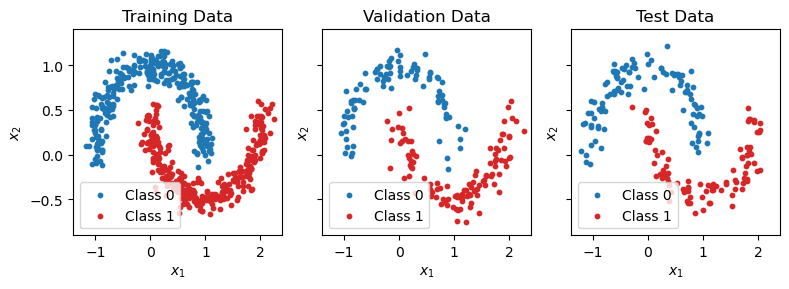

In [2]:
train_loader, val_loader, test_loader = create_moons_data_loaders(1_000, 1_000)
display_data_splits(train_loader, val_loader, test_loader)

In [3]:
input_size = 2
output_size = 2
hidden_size = 64

## NON SNGP EQUIVALENT MODEL
model = StandardThreeLayerDNN(in_features=input_size, hidden_size=hidden_size, out_features=output_size).to(device)
print(model)

StandardThreeLayerDNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


100%|██████████| 1001/1001 [00:13<00:00, 73.43it/s, tr_xent=0.00721, tr_err=0, va_xent=0.0102, va_err=0, batch_done=1]        


Finished after epoch 1000, best epoch=1000
{'data_order_seed': 42, 'lr': 0.1, 'n_epochs': 1000, 'l2pen_mag': 0.0, 'tr': {'xent': [nan, 0.6497398018836975, 0.6271846294403076, 0.6068616509437561, 0.5887192487716675, 0.572557270526886, 0.5581371188163757, 0.5452032685279846, 0.5335476398468018, 0.5229507088661194, 0.5132696628570557, 0.5043724179267883, 0.4961143136024475, 0.48840582370758057, 0.4811657965183258, 0.47435322403907776, 0.46789780259132385, 0.46176719665527344, 0.45594775676727295, 0.4503786563873291, 0.4450558125972748, 0.4399672746658325, 0.4350912868976593, 0.43039968609809875, 0.42589670419692993, 0.42157936096191406, 0.41742703318595886, 0.41342446208000183, 0.4095655381679535, 0.40585026144981384, 0.4022754728794098, 0.39882892370224, 0.39551323652267456, 0.39231210947036743, 0.38922756910324097, 0.3862434923648834, 0.38336169719696045, 0.38057786226272583, 0.37788626551628113, 0.37528350949287415, 0.372759073972702, 0.3703058958053589, 0.3679288327693939, 0.365618526

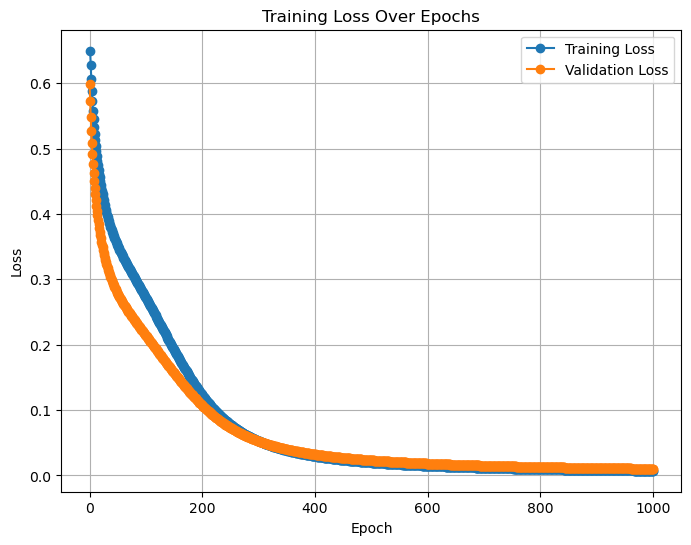

In [5]:
model, info = train_model(model, device, train_loader, val_loader, losses, n_epochs=1000, lr=0.1, do_early_stopping=True, model_filename="../results/notebook_results/models/vanilla_best_model.pth")
plot_loss(info)

torch.Size([160000, 2])


/Users/shanewilliams/GradSchool/Research/sngp-sandbox/src/viz_utils.py:530: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


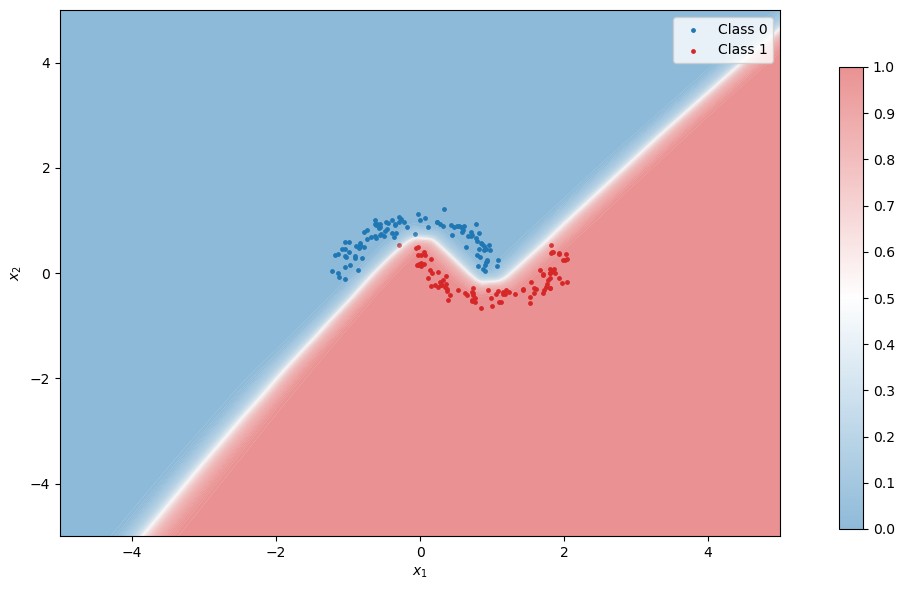

In [6]:
%reload_ext autoreload
plot_probabilities(model, test_loader, device=device, filename="../results/notebook_results/plots/vanilla_dnn_moons_probabilities.png")

In [7]:
%reload_ext autoreload
input_size = 2
output_size = 2
rank = 5_000
lengthscale = 0.25
outputscale = 1.0


sngp_model = RandomFeatureGaussianProcess(in_features=input_size, out_features=output_size, rank=rank, lengthscale=lengthscale, outputscale=outputscale).to(device)
print(sngp_model)

RandomFeatureGaussianProcess(
  (linear): Linear(in_features=5000, out_features=2, bias=False)
)


100%|██████████| 1001/1001 [00:10<00:00, 97.28it/s, tr_xent=0.00508, tr_err=0, va_xent=0.00786, va_err=0, batch_done=1]      


Finished after epoch 1000, best epoch=1000
{'data_order_seed': 42, 'lr': 2.0, 'n_epochs': 1000, 'l2pen_mag': 0.0, 'tr': {'xent': [nan, 0.9979845285415649, 0.8436381816864014, 0.7239885926246643, 0.6302288770675659, 0.5557103753089905, 0.49558356404304504, 0.44634807109832764, 0.40547066926956177, 0.3711008131504059, 0.34186995029449463, 0.3167518675327301, 0.2949666380882263, 0.2759133279323578, 0.25912317633628845, 0.24422597885131836, 0.2309262603521347, 0.2189856618642807, 0.20821000635623932, 0.19843977689743042, 0.18954282999038696, 0.1814088076353073, 0.17394496500492096, 0.16707277297973633, 0.16072532534599304, 0.15484541654586792, 0.14938369393348694, 0.14429742097854614, 0.13954950869083405, 0.13510751724243164, 0.13094298541545868, 0.12703083455562592, 0.12334892153739929, 0.11987762898206711, 0.1165994331240654, 0.11349870264530182, 0.11056147515773773, 0.10777517408132553, 0.1051284670829773, 0.10261117666959763, 0.10021401941776276, 0.09792862832546234, 0.0957473441958427

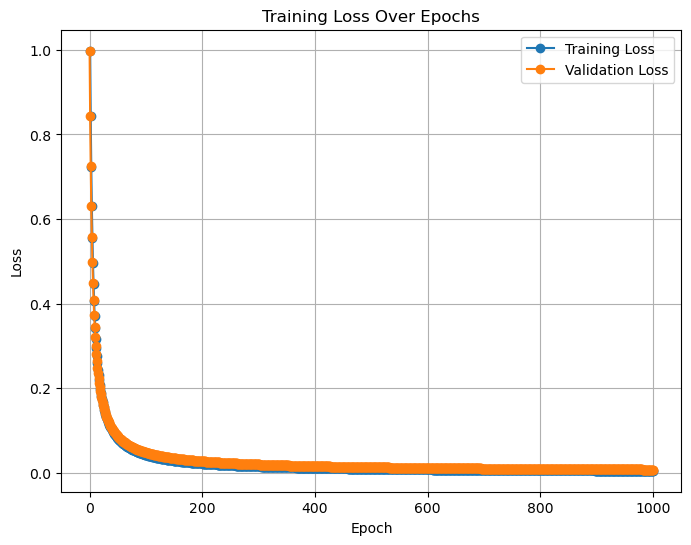

In [8]:
sngp_model, new_info = train_model(sngp_model, device, train_loader, val_loader, losses, n_epochs=1_000, lr=2.0, do_early_stopping=True, model_filename="../results/notebook_results/models/sngp_best_model.pth")
plot_loss(new_info)

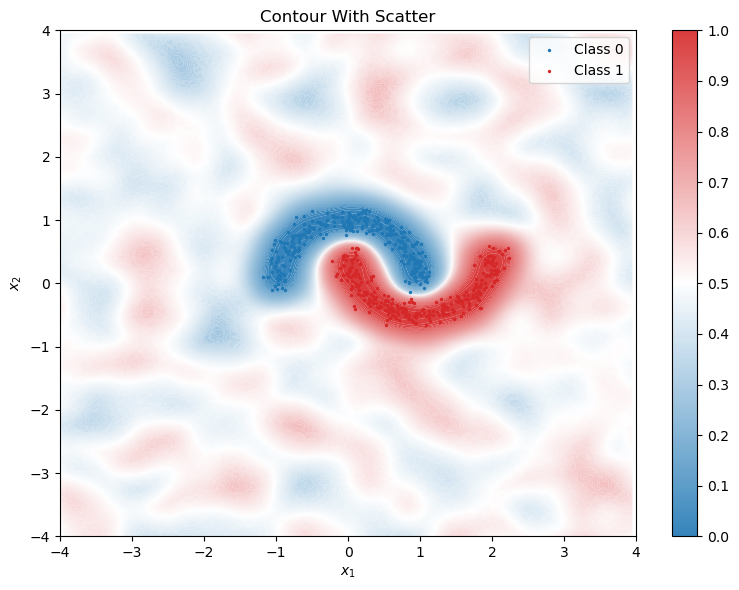

In [9]:
%reload_ext autoreload
plot_probabilities_gp(sngp_model, train_loader, num_samples=10_000, compute_covariance=True, device=device, preds_path="../results/notebook_results/preds/sngp_preds.pt", filename="../results/notebook_results/plots/sngp_moons_probabilities.png")

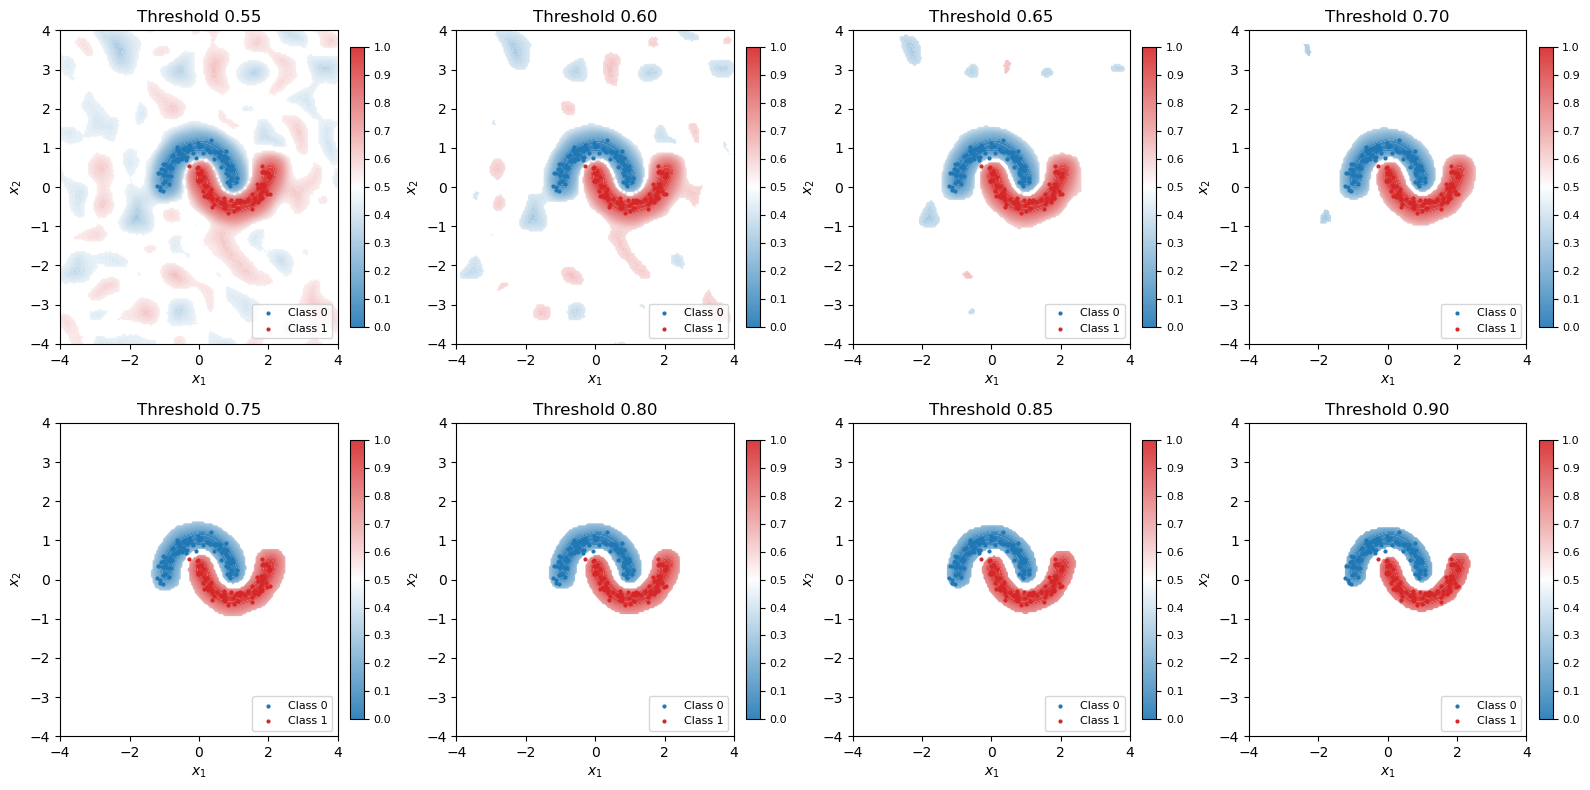

'../results/notebook_results/plots/sngp_moons_thresholded_predictions.png'

In [11]:
%reload_ext autoreload
preds_file = "../results/notebook_results/preds/sngp_preds.pt"
plot_thresholded_predictions(preds_file, test_loader, thresholds=[0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.90], filename="../results/notebook_results/plots/sngp_moons_thresholded_predictions.png")

# Using Deep Neural Network From Lui et. Al:

In [16]:
%reload_ext autoreload
input_size = 2
output_size = 2
rank = 1_024
lengthscale = 16.0
outputscale = 0.5


sngp_dnn_model = SNGP_ResFFN12_128(in_features=input_size, out_features=output_size, rank=rank, lengthscale=lengthscale, outputscale=outputscale)
apply_bounded_spectral_norm(sngp_dnn_model, name='weight', spec_norm_iteration=2, spec_norm_bound=6.0)
print(sngp_dnn_model)

SNGP_ResFFN12_128(
  (fc_in): ParametrizedLinear(
    in_features=2, out_features=128, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _BoundedSpectralNorm()
      )
    )
  )
  (relu): ReLU()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (fc): ParametrizedLinear(
        in_features=128, out_features=128, bias=True
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _BoundedSpectralNorm()
          )
        )
      )
      (dropout): Dropout(p=0.01, inplace=False)
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (fc): ParametrizedLinear(
        in_features=128, out_features=128, bias=True
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _BoundedSpectralNorm()
          )
        )
      )
      (dropout): Dropout(p=0.01, inplace=False)
      (relu): ReLU()
    )
    (2): ResidualBlock(
      (fc): ParametrizedLinear(
     

100%|██████████| 5001/5001 [02:32<00:00, 32.70it/s, tr_xent=0.105, tr_err=0, va_xent=0.109, va_err=0, batch_done=1]          


Finished after epoch 5000, best epoch=4999
{'data_order_seed': 42, 'lr': 0.01, 'n_epochs': 5000, 'l2pen_mag': 0.0, 'tr': {'xent': [nan, 1.000635027885437, 0.9999257922172546, 0.9995948076248169, 0.9990769028663635, 0.9987058043479919, 0.9981486797332764, 0.9978038668632507, 0.997219979763031, 0.9969378709793091, 0.9965370297431946, 0.9960190057754517, 0.9956760406494141, 0.9952493906021118, 0.994752049446106, 0.9942105412483215, 0.9939284920692444, 0.9936099648475647, 0.9933127164840698, 0.9927992820739746, 0.9923593401908875, 0.9918210506439209, 0.9915665984153748, 0.9908308386802673, 0.9906915426254272, 0.9901515245437622, 0.9898722767829895, 0.9894525408744812, 0.9892868399620056, 0.9886838793754578, 0.9881018996238708, 0.9880031943321228, 0.9874197840690613, 0.9868840575218201, 0.9867870211601257, 0.9863210916519165, 0.985988199710846, 0.9857146739959717, 0.9851373434066772, 0.9847787022590637, 0.9843958616256714, 0.9840126037597656, 0.9838157296180725, 0.9833843111991882, 0.982905

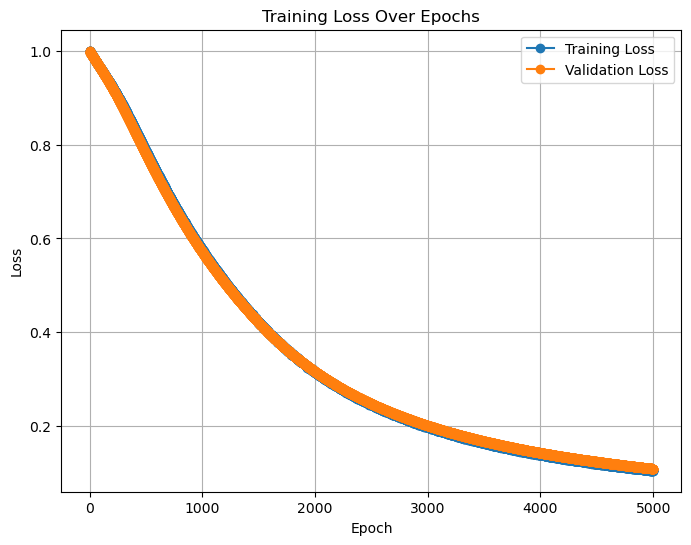

In [17]:
sngp_dnn_model, new_info = train_model(sngp_dnn_model, 'cpu', train_loader, val_loader, losses, n_epochs=5_000, lr=0.01, n_epochs_without_va_improve_before_early_stop=150, do_early_stopping=True, model_filename="../results/notebook_results/models/sngp_dnn_best_model.pth")
plot_loss(new_info)

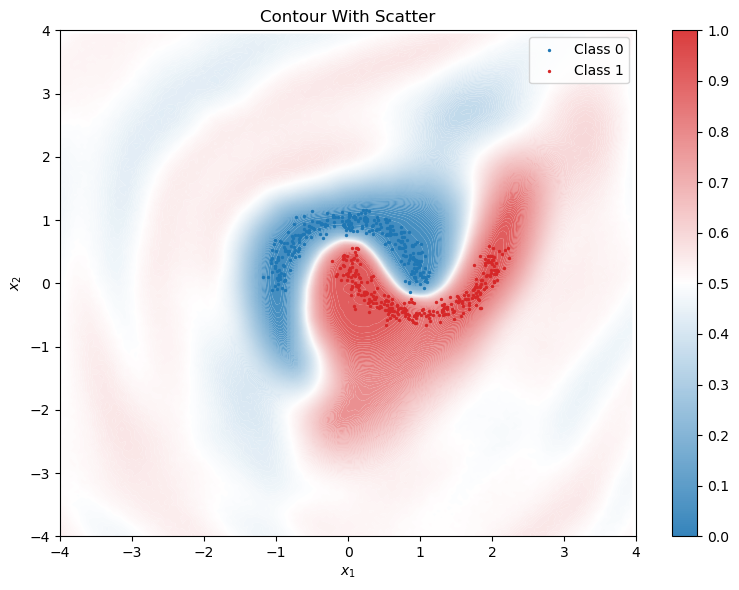

In [18]:
%reload_ext autoreload
plot_probabilities_gp(sngp_dnn_model, train_loader, num_samples=10_000, compute_covariance=True, device='cpu', preds_path="../results/notebook_results/preds/sngp_dnn_preds.pt", filename="../results/notebook_results/plots/sngp_dnn_moons_probabilities.png")

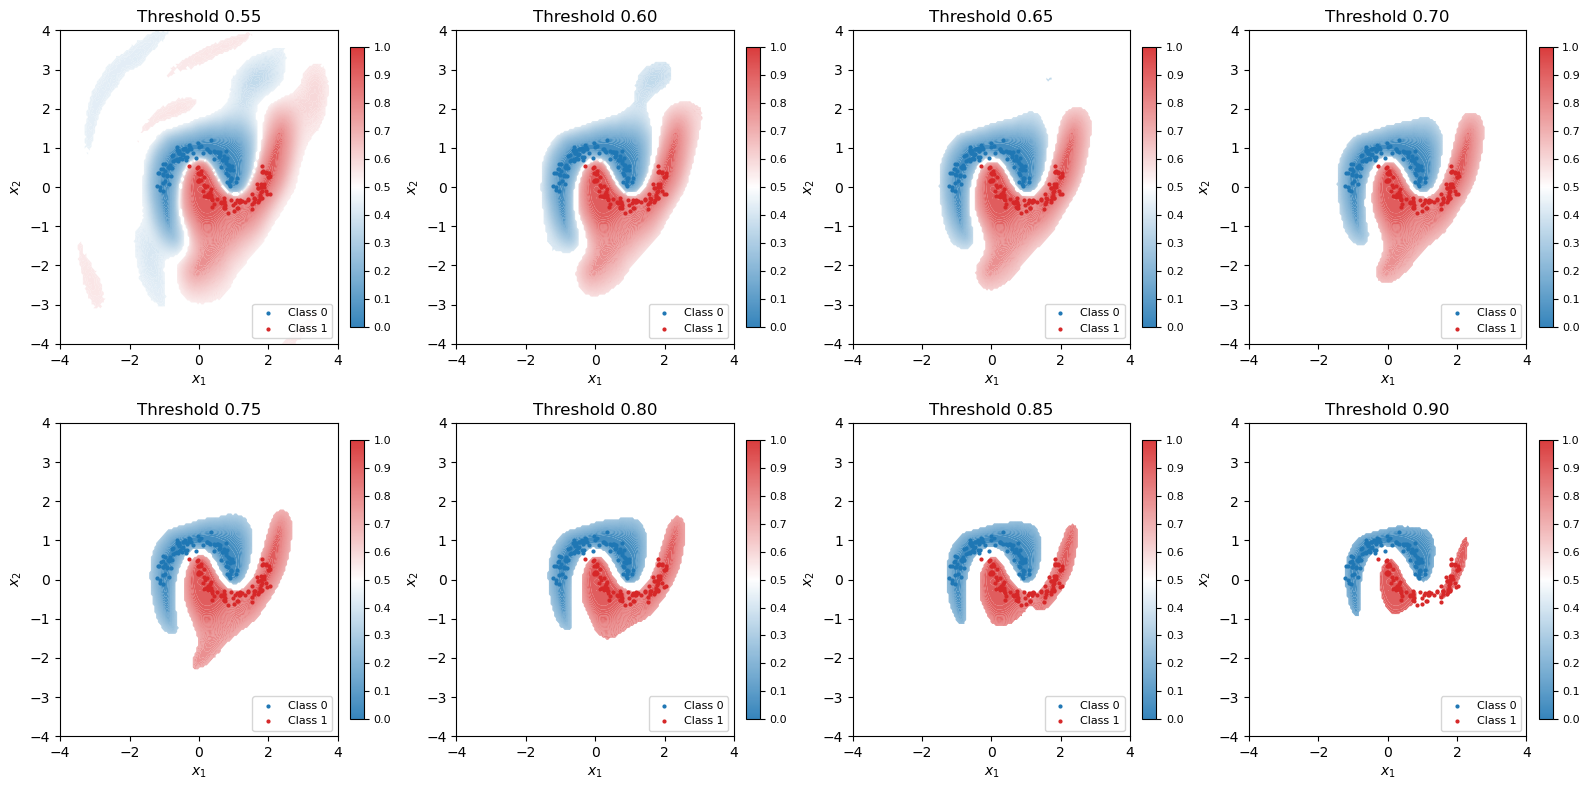

'../results/notebook_results/plots/sngp_dnn_moons_thresholded_predictions.png'

In [19]:
%reload_ext autoreload
preds_file = "../results/notebook_results/preds/sngp_dnn_preds.pt"
plot_thresholded_predictions(preds_file, test_loader, thresholds=[0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.90], filename="../results/notebook_results/plots/sngp_dnn_moons_thresholded_predictions.png")